In [ ]:
# === 1. IMPORT CÁC THƯ VIỆN CẦN THIẾT ===
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# === 2. THIẾT LẬP CÁC ĐƯỜNG DẪN DỮ LIỆU ===
# Lưu ý: Vì notebook đang ở trong thư mục /notebooks, chúng ta dùng ../ để đi ra ngoài một cấp
base_dir = '../data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

# === 3. TẠO CÁC BỘ DỮ LIỆU (DATA GENERATORS) ===
# Keras ImageDataGenerator sẽ giúp chúng ta tải ảnh từ các thư mục,
# đồng thời tự động gán nhãn dựa trên tên thư mục.

# Áp dụng một vài phép tăng cường dữ liệu (data augmentation) cho tập train
# để giúp mô hình học tốt hơn và tránh học vẹt
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Không cần tăng cường dữ liệu cho tập validation
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Tạo các generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # Thay đổi kích thước tất cả ảnh về 224x224
    batch_size=32,
    class_mode='categorical' # Vì chúng ta có nhiều lớp bệnh
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# === 4. HIỂN THỊ THỬ MỘT VÀI ẢNH ===
# Lấy một lô (batch) ảnh từ generator
for image_batch, label_batch in train_generator:
    print("Kích thước lô ảnh:", image_batch.shape)
    print("Kích thước lô nhãn:", label_batch.shape)
    break

# Lấy ra tên của các lớp bệnh
class_names = list(train_generator.class_indices.keys())

# Hiển thị 9 ảnh đầu tiên trong lô
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    # Tìm tên lớp tương ứng với one-hot vector
    class_index = np.argmax(label_batch[i])
    plt.title(class_names[class_index].split('___')[1].replace('_', ' '))
    plt.axis("off")
plt.show()

In [ ]:
# === CHẠY CELL NÀY ĐỂ TẠO FILE JSON ===
import json

# Lấy "cuốn từ điển" từ train_generator vừa được tạo
class_indices = train_generator.class_indices

# Lưu vào file json trong thư mục artifacts
file_path = '../artifacts/class_indices.json'
with open(file_path, 'w') as f:
    json.dump(class_indices, f)

print(f"Đã lưu thành công danh sách lớp vào: {file_path}")
print("Bây giờ bạn có thể đóng Jupyter Notebook.")

In [4]:
# === 1. SỬ DỤNG TRANSFER LEARNING VỚI MOBILENETV2 ===
# Tải về mô hình MobileNetV2 đã được huấn luyện trên bộ dữ liệu ImageNet
# include_top=False có nghĩa là chúng ta không lấy lớp phân loại cuối cùng của nó
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Đóng băng các lớp của base_model để chúng không bị thay đổi trong quá trình huấn luyện
base_model.trainable = False

# In ra kiến trúc của mô hình nền
# base_model.summary()

# === 2. XÂY DỰNG "CÁI ĐẦU" MỚI CHO MÔ HÌNH ===
# Chúng ta sẽ thêm các lớp phân loại của riêng mình vào phía trên base_model
model = tf.keras.Sequential([
    base_model, # Mô hình nền
    tf.keras.layers.GlobalAveragePooling2D(), # Gom các đặc trưng lại
    tf.keras.layers.Dense(128, activation='relu'), # Một lớp ẩn để học các mối quan hệ phức tạp
    tf.keras.layers.Dropout(0.5), # Thêm dropout để giảm thiểu overfitting
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax') # Lớp đầu ra, số nơ-ron bằng số lớp bệnh
])

# === 3. BIÊN DỊCH (COMPILE) MÔ HÌNH ===
# Cấu hình các tham số cho quá trình huấn luyện
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# In ra kiến trúc của mô hình hoàn chỉnh của chúng ta
model.summary()


# === 4. HUẤN LUYỆN MÔ HÌNH ===
print("\nBắt đầu quá trình huấn luyện...")
# Quá trình này có thể mất một lúc tùy thuộc vào sức mạnh máy tính của bạn
EPOCHS = 10 # Chúng ta sẽ huấn luyện trong 10 vòng lặp

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

print("\nHoàn tất quá trình huấn luyện!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Bắt đầu quá trình huấn luyện...


E:\AI traning\plant-doctor-ai\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 5472s 2s/step - accuracy: 0.5361 - loss: 1.6092 - val_accuracy: 0.8673 - val_loss: 0.4064
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3575s 2s/step - accuracy: 0.7833 - loss: 0.6754 - val_accuracy: 0.8903 - val_loss: 0.3261
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3191s 1s/step - accuracy: 0.8085 - loss: 0.5897 - val_accuracy: 0.8988 - val_loss: 0.2994
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2892s 1s/step - accuracy: 0.8165 - loss: 0.5632 - val_accuracy: 0.9008 - val_loss: 0.2987
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3017s 1s/step - accuracy: 0.8263 - loss: 0.5247 - val_accuracy: 0.9087 - val_loss: 0.2765
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2895s 1s/step - accuracy: 0.8335 - loss: 0.5101 - val_accuracy: 0.9110 - val_loss: 0.2619
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2909s 1s/step - accuracy: 0.8381 - loss: 0.4961 - val_accuracy: 0.9123 - val_loss: 0.2578
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2899s 1s/step - accuracy: 0.8411 -

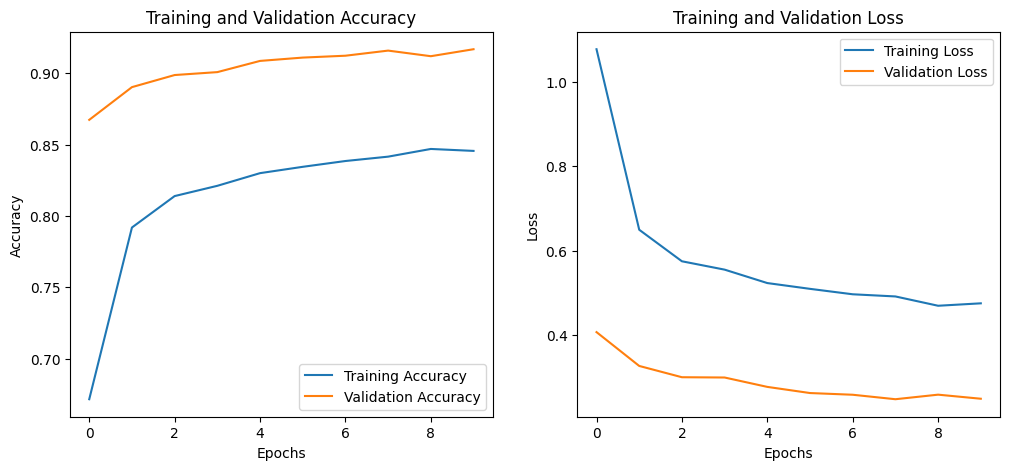

In [5]:
# Lấy ra các kết quả từ quá trình huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) # Số epoch đã chạy

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Vẽ biểu đồ độ lỗi
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [6]:
# Lưu mô hình đã huấn luyện vào thư mục artifacts
model_path = '../artifacts/plant_doctor_model.h5'
model.save(model_path)

print(f"Mô hình đã được lưu thành công tại: {model_path}")

Mô hình đã được lưu thành công tại: ../artifacts/plant_doctor_model.h5


In [7]:
# Chạy trong Jupyter Notebook

# 1. Tải lại mô hình từ file đã lưu trong thư mục artifacts
print("Đang tải lại mô hình từ file...")
saved_model_path = '../artifacts/plant_doctor_model.h5'
loaded_model = tf.keras.models.load_model(saved_model_path)
print("Tải mô hình thành công!")

# 2. Đánh giá mô hình trên tập dữ liệu kiểm tra (validation set)
# Chúng ta sẽ sử dụng lại validation_generator đã được tạo ở các cell trên
# Nếu chưa có, bạn cần chạy lại cell tạo validation_generator
print("\nBắt đầu đánh giá mô hình trên tập kiểm tra...")
results = loaded_model.evaluate(validation_generator)

print("\n--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"Độ lỗi (Loss) trên tập kiểm tra: {results[0]:.4f}")
print(f"Độ chính xác (Accuracy) trên tập kiểm tra: {results[1]*100:.2f}%")

Đang tải lại mô hình từ file...


Tải mô hình thành công!

Bắt đầu đánh giá mô hình trên tập kiểm tra...
550/550 ━━━━━━━━━━━━━━━━━━━━ 397s 712ms/step - accuracy: 0.9156 - loss: 0.2521

--- KẾT QUẢ ĐÁNH GIÁ ---
Độ lỗi (Loss) trên tập kiểm tra: 0.2483
Độ chính xác (Accuracy) trên tập kiểm tra: 91.69%
